# 변동성 돌파 개선

## 종목 선정
- 노이즈 필터링

```json
{
    "meta": {
        "symbol": "233740",
        "interval": "1h",
        "currency": "KRW",
        "exchange_timezone": "Asia/Seoul",
        "exchange": "KRX",
        "mic_code": "XKRX",
        "type": "ETF"
    },
    "values": [
        {
            "datetime": "2024-04-30 15:00:00",
            "open": "11980.00000",
            "high": "11990.00000",
            "low": "11920.00000",
            "close": "11935.00000",
            "volume": "552927",
            "previous_close": "11975.00000"
        },
```

[Kodex 코스닥150 레버리지](https://www.samsungfund.com/etf/product/view.do?id=2ETF56)

In [25]:
import json
import pandas as pd

with open('time_series_233740_1h.json') as f:
    data = json.load(f)
    
df = pd.DataFrame(data['values'])
df

,datetime,open,high,low,close,volume,previous_close
0,2024-04-30 15:00:00,11980.00000,11990.00000,11920.00000,11935.00000,552927,11975.00000
1,2024-04-30 14:00:00,11945.00000,11985.00000,11870.00000,11975.00000,2189572,11940.00000
2,2024-04-30 13:00:00,12030.00000,12035.00000,11915.00000,11940.00000,1724148,12025.00000
3,2024-04-30 12:00:00,12020.00000,12050.00000,11985.00000,12025.00000,1238633,12020.00000
4,2024-04-30 11:00:00,11990.00000,12040.00000,11985.00000,12020.00000,1447822,11990.00000
...,...,...,...,...,...,...,...
4301,2021-10-12 13:00:00,13465.00000,13560.00000,13410.00000,13545.00000,1085466,13465.00000
4302,2021-10-12 12:00:00,13590.00000,13645.00000,13460.00000,13465.00000,1122965,13585.00000
4303,2021-10-12 11:00:00,13650.00000,13705.00000,13520.00000,13585.00000,1030021,13645.00000
4304,2021-10-12 10:00:00,13580.00000,13695.00000,13510.00000,13645.00000,1311789,13580.00000


## 주가(종가) 추이 보기

날짜별 종가를 시각화하여 주가 추이를 확인한다

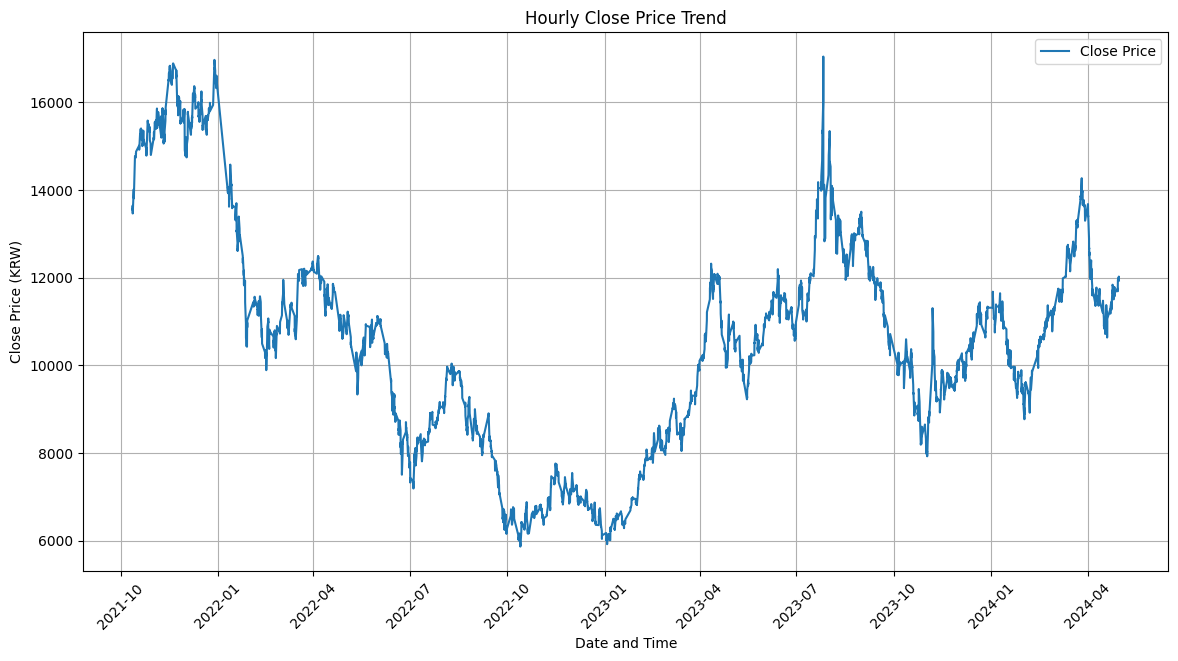

In [30]:
import matplotlib.pyplot as plt

# Convert datetime column to pandas datetime type
df['datetime'] = pd.to_datetime(df['datetime'])

# Sort dataframe by datetime
df = df.sort_values(by='datetime')

# Convert the 'close' column to numeric type
df['close'] = pd.to_numeric(df['close'])

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(df['datetime'], df['close'], label='Close Price')

plt.title('Hourly Close Price Trend')
plt.xlabel('Date and Time')
plt.ylabel('Close Price (KRW)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate datetime labels for better readability
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

## 노이즈 비교

상대적으로 효율적인 시장과 **Kodex 코스닥150 레버리지** 의 평균 노이즈를 비교해보자

- [Kodex 코스피](https://www.samsungfund.com/etf/product/view.do?id=2ETF52)
- [S&P 500](https://kr.investing.com/indices/us-spx-500)

### 캔들의 노이즈 구하기

$
\text{노이즈} = 1 - \frac{|\text{시가} - \text{종가}|}{\text{고가} - \text{저가}}
$

> 실제로 코스닥 지수와 코스피 지수의 노이즈값을 평균해보면, 코스닥은 0.42인데 반해, 코스피는 0.5가 넘습니다. 해외 지수를 가지고 테스트해보면 변동성 돌파 전략이 잘 먹히지 않는 종목은 노이즈값이 0.5 이상으로 큰데 비해, 기가막힌 수익 곡선을 보여주는 경우는 노이즈값이 0.4정도를 보여줍니다. 대표적으로 베트남 지수도 코스닥과 유사한 0.4정도입니다. 
출처: https://stock79.tistory.com/entry/실전-투자-전략-52-Noise-ratio를-이용한-변동성-돌파-전략-개선 [systrader79의 왕초보를 위한 주식 투자:티스토리]

In [40]:
import json
import pandas as pd

def get_noise(open, high, low, close):
    try:
        high = pd.to_numeric(high)
        low = pd.to_numeric(low)
        open = pd.to_numeric(open)
        close = pd.to_numeric(close)
        
        if high == low:  # Avoid division by zero
            return 0
        
        return 1 - abs(open - close) / (high - low)
    except Exception as e:
        return 0  # or handle it in a way that suits your needs

# Read JSON files
with open('time_series_233740_1h.json') as f:
    j2ETF52 = json.load(f)  # Kodex 코스닥150 레버리지
    
with open('time_series_233740_1h.json') as f:
    j233740 = json.load(f)  # Kodex 코스피
    
with open('time_series_SPX_1h.json') as f:
    jSPX = json.load(f)  # S&P 500

# Create dataframes
df2ETF52 = pd.DataFrame(j2ETF52['values'])
df233740 = pd.DataFrame(j233740['values'])
dfSPX = pd.DataFrame(jSPX['values'])

# Calculate noise
df2ETF52['noise'] = df2ETF52.apply(lambda x: get_noise(x['open'], x['high'], x['low'], x['close']), axis=1)
df233740['noise'] = df233740.apply(lambda x: get_noise(x['open'], x['high'], x['low'], x['close']), axis=1)
dfSPX['noise'] = dfSPX.apply(lambda x: get_noise(x['open'], x['high'], x['low'], x['close']), axis=1)

# Calculate average noise
avg_noise_2ETF52 = df2ETF52['noise'].mean()
avg_noise_233740 = df233740['noise'].mean()
avg_noise_SPX = dfSPX['noise'].mean()

print(f'Average noise of Kodex 코스닥150 레버리지: {avg_noise_2ETF52:.2f}')
print(f'Average noise of Kodex 코스피: {avg_noise_233740:.2f}')
print(f'Average noise of S&P 500: {avg_noise_SPX:.2f}')


Average noise of Kodex 코스닥150 레버리지: 0.52
Average noise of Kodex 코스피: 0.52
Average noise of S&P 500: 0.51
